# Scénario 1 – Distribution prioritaire
Dans ce scénario, le réseau de chaleur (l’arbre couvrant) est construit en tenant compte d’un critère de priorisation des consommateurs. Étant donné que le réseau ne pourra pas desservir l’ensemble des usagers, une sélection est effectuée afin de garantir que les consommateurs jugés prioritaires (ex : hôpitaux, industries stratégiques, zones à forte demande) soient servis en premier.

In [90]:
"""
from google.colab import files
import os
import shutil

uploaded = files.upload()
dest_path = "/content/data/"
os.makedirs(os.path.dirname(dest_path), exist_ok=True)
shutil.move("/content/InputDataEnergyEquity.xlsx", dest_path)
#shutil.move("/content/InputDataEnergyLargeInstance.xlsx", dest_path)
#shutil.move("/content/InputDataEnergySmallInstance.xlsx", dest_path)
shutil.rmtree("/content/sample_data/", ignore_errors=True, onerror=None)
"""

'\nfrom google.colab import files\nimport os\nimport shutil\n\nuploaded = files.upload()\ndest_path = "/content/data/"\nos.makedirs(os.path.dirname(dest_path), exist_ok=True)\nshutil.move("/content/InputDataEnergyEquity.xlsx", dest_path)\n#shutil.move("/content/InputDataEnergyLargeInstance.xlsx", dest_path)\n#shutil.move("/content/InputDataEnergySmallInstance.xlsx", dest_path)\nshutil.rmtree("/content/sample_data/", ignore_errors=True, onerror=None)\n'

In [91]:
!pip install pulp
!pip install networkx matplotlib

In [92]:
# Import PuLP modeler functions
from pulp import *
import pandas as pd
import numpy as np

In [93]:
InputData = "/content/data/InputDataEnergyEquity.xlsx"

In [94]:
# Input Data Preparation
def read_excel_data(filename, sheet_name):
  data = pd.read_excel(filename, sheet_name=sheet_name, header=None)
  values = data.values
  if min(values.shape) == 1:  # This If is to make the code insensitive to column-wise or row-wise expression
      if values.shape[0] == 1:
          values = values.tolist()
      else:
          values = values.transpose()
          values = values.tolist()
      return values[0]
  else:
      data_dict = {}
      if min(values.shape) == 2:  # For single-dimension parameters in Excel
          if values.shape[0] == 2:
              for i in range(values.shape[1]):
                  data_dict[i] = values[1][i]
          else:
              for i in range(values.shape[0]):
                  data_dict[i] = (values[i][0],values[i][1])

      else:  # For two-dimension (matrix) parameters in Excel
          for i in range(values.shape[0]):
              for j in range(values.shape[1]):
                  data_dict[(i, j)] = values[i][j]
      return data_dict

In [95]:
#parameters
Nodes = read_excel_data(InputData, "Nodes")
NodesCord = read_excel_data(InputData, "NodesCord")
V = [i for i in range(0,Nodes[0])]
E = [(i, j) for i in range(0, Nodes[0] ) for j in range(0, Nodes[0] )]
l={}
for i in range(Nodes[0]):
    for j in range(Nodes[0]):
        l[(i,j)]=((NodesCord[i][0]-NodesCord[j][0])**2+(NodesCord[i][1]-NodesCord[j][1])**2)**(1/2)

V0 = read_excel_data(InputData, "SourceNum")
for i in range(len(V0)):
  V0[i]=V0[i]-1
  print(V0)

FixedUnitCost = read_excel_data(InputData, "FixedUnitCost")
crev_cijrev = read_excel_data(InputData, "crev(cijrev)")
cheat_ciheat = read_excel_data(InputData, "cheat(ciheat)")
cvar_cijvar = read_excel_data(InputData, "cvar(cijvar)")
vvar_thetaijvar = read_excel_data(InputData, "vvar(thetaijvar)")
vfix_thetaijfix = read_excel_data(InputData, "vfix(thetaijfix)")
Betta = read_excel_data(InputData, "Betta")
Lambda = read_excel_data(InputData, "Lambda")
Alpha = read_excel_data(InputData, "Alpha")
EdgesDemandPeak_i = read_excel_data(InputData, "EdgesDemandPeak(i)")
Surface_i = read_excel_data(InputData, "Surface(i)")
SurfaceConsumption_i = read_excel_data(InputData, "SurfaceConsumption(i)")
Cmax_cijmax = read_excel_data(InputData, "Cmax(cijmax)")
com_cijom = read_excel_data(InputData, "com(cijom)")
SourceMaxCap_Qimax = read_excel_data(InputData, "SourceMaxCap(Qimax)")
ConsumerType_i = read_excel_data(InputData, "ConsumerType(i)")
EquityThreshold = read_excel_data(InputData, "EquityThreshold")
ConsumerTypeNumber = read_excel_data(InputData, "ConsumerTypeNumber")

[3]


In [96]:
#decision variables
X=LpVariable.dicts("X",(V,V),lowBound=0,upBound=1,cat="Binary")
P_Out=LpVariable.dicts("P_Out",(V,V),lowBound=0,upBound=None,cat="Continuous")
P_In=LpVariable.dicts("P_In",(V,V),lowBound=0,upBound=None,cat="Continuous")
problem=LpProblem("problem",LpMaximize)

In [97]:
#EdgesDemandPeak
EdgesDemandPeak_dij = {}
for i in range(len(V)):
  for j in range(len(V)):
    if i != j:
      EdgesDemandPeak_dij[(i,j)] = EdgesDemandPeak_i[j]
    else:
      EdgesDemandPeak_dij[(i,j)] = 0

#EdgesDemandAnnual
EdgesDemandAnnual_dij = {}
for i in range(len(V)):
  for j in range(len(V)):
    if i != j:
      EdgesDemandAnnual_dij[(i,j)] = Surface_i[j]*SurfaceConsumption_i[j]
    else:
      EdgesDemandAnnual_dij[(i,j)] = 0

In [98]:
"""
# Constraint 0
sum_x =[]
for i in range(len(V)):
  for j in range(len(V)):
    sum_x.append(X[i][j])
problem += lpSum(sum_x) == len(V) - 1
"""

# Constraint 1
for i in range(len(V)):
  if i not in V0:
    problem += lpSum([X[j][i] for j in range(len(V)) if j != i]) <= 1

# Constraint 2
for i in range(len(V)):
    for j in range(i,len(V)):
        problem += lpSum([X[i][j],X[j][i]]) <= 1

# Constraint 3
for (i,j) in E:
    eta = 1 - vvar_thetaijvar[(i,j)]*l[(i,j)]
    delta = EdgesDemandPeak_dij[(i,j)]*Betta[0]*Lambda[0] + l[(i,j)]*vfix_thetaijfix[(i,j)]
    problem += lpSum([eta*P_In[i][j],-P_Out[i][j],-delta*X[i][j]]) == 0

# Constraint 4
"""for j in range(4,len(V)):
    sum_out_in= []
    for i in range(len(V)):
        if i != j:
            sum_out_in.append(P_Out[i][j])
            sum_out_in.append(-P_In[j][i])
            problem +=lpSum(sum_out_in) == 0"""
for j in range(0,len(V)):
  if j not in V0:
    problem += lpSum(P_Out[i][j]-P_In[j][i] for i in range(len(V)) if i != j) == 0

# Constraint 5
for i in range(len(V)):
  for j in range(len(V)):
    problem += lpSum([P_In[i][j],-X[i][j]*Cmax_cijmax[(i,j)] ]) <= 0

# Constraint 6
for v in V0:
  for i in range(len(V)):
    if i != v:
      problem += X[i][v] == 0
      problem += P_In[i][v] == 0
"""problem += sum_X == 0"""

# Constraint 7
for v in V0:
  sum_PIN =[]
  for i in range(len(V)):
      if i != v:
          sum_PIN.append(P_In[v][i])
  problem += lpSum(sum_PIN) <= SourceMaxCap_Qimax[0]


# Constraint 8
"""
for i in range(0,len(V)):
  if i not in V0:
    summ=[]
    for j in range(len(V)):
        if j!=i:
          summ.append(X[j][i])
    problem += lpSum(summ) >= 1
"""


# Constraint 8bis
"""
consumertype = {}
for k in range(ConsumerTypeNumber[0]):
  consumertype[k] = []

for i in range(len(V)):
  consumertype[ConsumerType_i[i]-1].append(i)

for t in range(ConsumerTypeNumber[0]):
  for i in range(len(V)):
    if i not in V0:
      problem += lpSum([X[j][i] for j in range(len(V)) if j != i]) >= lpSum([X[j][k] for j in range(len(V)) for k in range(len(V)) if j != k])*EquityThreshold[t]
"""
"""
for i in range(len(V)):
  if i not in V0:
     problem += lpSum([X[j][i] for j in range(len(V)) if j != i]) >= lpSum([X[j][k] for j in range(len(V)) for k in range(len(V)) if j != k])*EquityThreshold[ConsumerType_i[i]-1]
"""
"""for t in range(1,ConsumerTypeNumber[0]+1):
  vertices_with_type_t=[i for i in range(len(V)) if ConsumerType_i[i]==t]
  S_t=0
  mu_t=EquityThreshold[t-1]
  for i in vertices_with_type_t:
    S_t+=lpSum([X[j][i] for j in range(len(V)) if j!=i])
    problem+=S_t >= mu_t*lpSum([X[k][l] for k in range(len(V)) for l in range(len(V))])"""
    #problem+=S_t >= mu_t*S_t
for t in range(1, ConsumerTypeNumber[0] + 1):  # Pour chaque type t
    mu_t = EquityThreshold[t - 1]

    # Flux total dans le réseau (hors boucles)
    total_flow = lpSum([X[l][k] for l in range(len(V)) for k in range(len(V)) if l != k])

    # Somme des flux entrants vers les sommets de type t hors V0
    sum_incoming_type_t = lpSum([
        X[j][i] * (1 if ConsumerType_i[i] == t else 0)
        for i in range(len(V)) if i not in V0
        for j in range(len(V)) if j != i
    ])

    # Ajout de la contrainte
    problem += (sum_incoming_type_t >= mu_t * total_flow)


# Constraint 9
for i in range(len(V)):
  for j in range(len(V)):
    problem += P_In[i][j] >= 0
    problem += P_Out[i][j] >= 0
    problem += X[i][j] >= 0
    problem += X[i][j] <= 1

In [99]:
#objective function
n=len(V)

#revenue
revenue=0
for i in range(n):
  for j in range(n):
    revenue+=crev_cijrev[0]*EdgesDemandAnnual_dij[(i,j)]*Lambda[0]*X[i][j]

#Heat generation
heat_generation=0
for j in range(n):
  for v in V0:
    if EdgesDemandPeak_dij[(v,j)] != 0:
    # on a plus tflh
      Tflh_Tiflh = EdgesDemandAnnual_dij[(v,j)]/EdgesDemandPeak_dij[(v,j)]  # revoir indice de tuple
      heat_generation+=P_In[v][j]*Tflh_Tiflh*cheat_ciheat[0]
heat_generation=(1/Betta[0])*heat_generation

#maintenance
maintenance=0
for i in range(n):
  for j in range(n):
    maintenance+=com_cijom[(i,j)]*l[(i,j)]*X[i][j]

#total fixed investment cost
total_fixed_investment_cost=0
for i in range(Nodes[0]):
    for j in range(Nodes[0]):
        total_fixed_investment_cost+=l[(i,j)]*FixedUnitCost[0]*X[i][j]*Alpha[0]

#total variable investment cost
total_var=0
for i in range(n):
  for j in range(n):
    total_var+=cvar_cijvar[(i,j)]*P_In[i][j]*l[(i,j)]*Alpha[0]

#unmet demand
"""
unmet_demand=0
for i in range(n):
  for j in range(i+1,n):
    unmet_demand+=lpSum([1,-X[i][j],-X[j][i]])*pumd_pijumd[(i,j)]*EdgesDemandAnnual_dij[(i,j)]
"""

#objective function
objective_function=(revenue-heat_generation-maintenance-total_fixed_investment_cost-total_var)
problem+=objective_function
problem.solve()
LpStatus[problem.status]


'Optimal'

In [100]:
for v in problem.variables():
  print(v.name,"=",v.varValue)
print("objective_function","=",value(problem.objective))


P_In_0_0 = 0.0
P_In_0_1 = 0.0
P_In_0_10 = 0.0
P_In_0_11 = 0.0
P_In_0_12 = 0.0
P_In_0_13 = 0.0
P_In_0_14 = 0.0
P_In_0_15 = 0.0
P_In_0_16 = 0.0
P_In_0_17 = 0.0
P_In_0_18 = 0.0
P_In_0_19 = 0.0
P_In_0_2 = 0.0
P_In_0_3 = 0.0
P_In_0_4 = 0.0
P_In_0_5 = 0.0
P_In_0_6 = 503.75468
P_In_0_7 = 0.0
P_In_0_8 = 0.0
P_In_0_9 = 0.0
P_In_10_0 = 0.0
P_In_10_1 = 0.0
P_In_10_10 = 0.0
P_In_10_11 = 0.0
P_In_10_12 = 0.0
P_In_10_13 = 0.0
P_In_10_14 = 0.0
P_In_10_15 = 0.0
P_In_10_16 = 0.0
P_In_10_17 = 0.0
P_In_10_18 = 0.0
P_In_10_19 = 0.0
P_In_10_2 = 0.0
P_In_10_3 = 0.0
P_In_10_4 = 0.0
P_In_10_5 = 0.0
P_In_10_6 = 0.0
P_In_10_7 = 0.0
P_In_10_8 = 1124.9383
P_In_10_9 = 0.0
P_In_11_0 = 0.0
P_In_11_1 = 0.0
P_In_11_10 = 0.0
P_In_11_11 = 0.0
P_In_11_12 = 0.0
P_In_11_13 = 0.0
P_In_11_14 = 0.0
P_In_11_15 = 0.0
P_In_11_16 = 0.0
P_In_11_17 = 0.0
P_In_11_18 = 0.0
P_In_11_19 = 0.0
P_In_11_2 = 0.0
P_In_11_3 = 0.0
P_In_11_4 = 0.0
P_In_11_5 = 0.0
P_In_11_6 = 0.0
P_In_11_7 = 0.0
P_In_11_8 = 0.0
P_In_11_9 = 0.0
P_In_12_0 = 0.0
P_

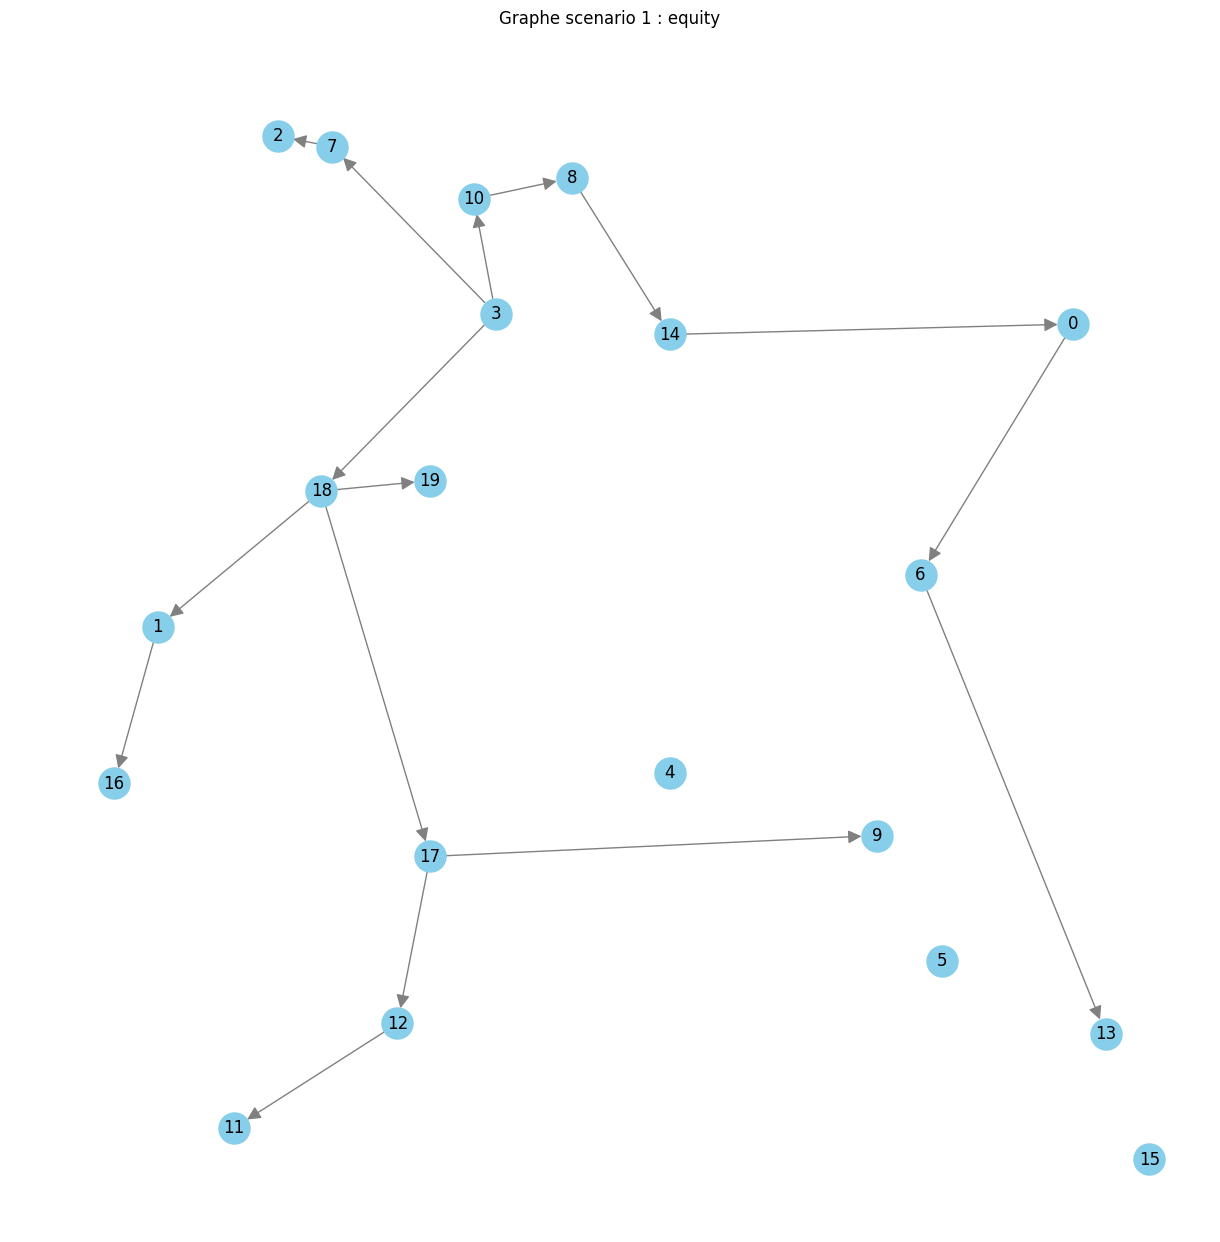

In [101]:
import networkx as nx
import matplotlib.pyplot as plt

# Extract edges from the solution
edges = []
for var in problem.variables():
    if var.name.startswith("X_") and var.varValue == 1:
        # Parse indices (e.g., "X_0_25" -> (0, 25))
        parts = var.name.split("_")
        i = int(parts[1])
        j = int(parts[2])
        edges.append((i, j))

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(V)

# Add edges
G.add_edges_from(edges)

# Extract node coordinates from NodesCord (convert np.int64 to float)
pos = {node: (float(NodesCord[node][0]), float(NodesCord[node][1])) for node in NodesCord}

# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500,
        edge_color='gray', arrows=True, arrowsize=20)
plt.title("Graphe scenario 1 : equity")
plt.show()